# <b> 423_liulim_Final Project_Fall 2019</b>
#### <i>-- Handwritten Text Recognition</i> 

In [0]:
## Mount Google Drive to use the file in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## Imports Modules
from __future__ import division
import numpy as np
import os
import glob
from PIL import Image
from random import *
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Import keras to create nerual network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

Using TensorFlow backend.


In [0]:
## Create a mapping for all writers
## Create a dictionary with image form and writer mapping
d = {}
with open('/content/drive/My Drive/forms_for_parsing.txt') as f:
    content = f.readlines()
    for line in content:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer

In [0]:
content[0]

'a01-000u 000 2 prt 7 5 52 36\n'

In [0]:
# Create array of image names and corresponding target writer names
tmp = []
target_list = []
path_to_files = os.path.join('/content/drive/My Drive/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)

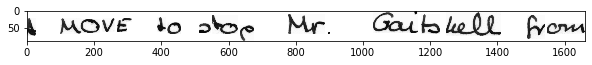

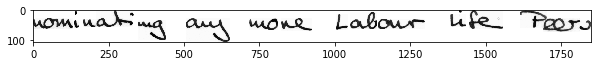

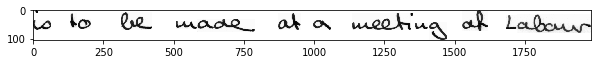

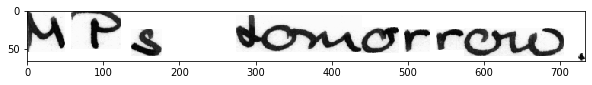

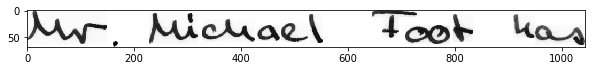

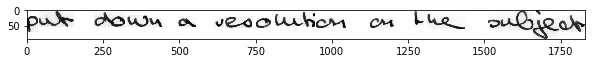

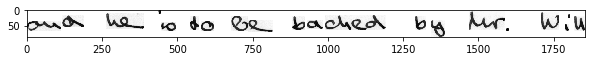

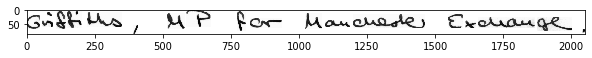

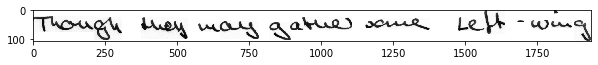

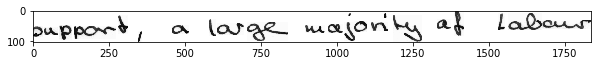

In [0]:
# Test to show visualization of the first 10 image in gray color map
for filename in img_files[:10]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [0]:
# Encode
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:10], img_targets[:10], encoded_Y[:10])

['/content/drive/My Drive/data_subset/a01-000u-s00-00.png'
 '/content/drive/My Drive/data_subset/a01-000u-s00-01.png'
 '/content/drive/My Drive/data_subset/a01-000u-s00-02.png'
 '/content/drive/My Drive/data_subset/a01-000u-s00-03.png'
 '/content/drive/My Drive/data_subset/a01-000u-s01-00.png'
 '/content/drive/My Drive/data_subset/a01-000u-s01-01.png'
 '/content/drive/My Drive/data_subset/a01-000u-s01-02.png'
 '/content/drive/My Drive/data_subset/a01-000u-s01-03.png'
 '/content/drive/My Drive/data_subset/a01-003u-s00-00.png'
 '/content/drive/My Drive/data_subset/a01-003u-s00-01.png'] ['000' '000' '000' '000' '000' '000' '000' '000' '000' '000'] [0 0 0 0 0 0 0 0 0 0]


In [0]:
## Import the sklearn module
from sklearn.model_selection import train_test_split

## Split the original dataset to train, test and validation by 4:1:1
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [0]:
batch_size = 16
num_classes = 50

## Create a funtion for generate data
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # While loop so the look will never end
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []

            ## Resize
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 )) # total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)
                random_startx = sample(avail_x_points,  pick_num)


                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            
            X_train = np.array(images)
            y_train = np.array(targets)

            ## Reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)

            ## Convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            ## Convert y to one hot vector
            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

In [0]:
# Generate data for training, testing and validation
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [0]:
## Build a neural network in Keras

## Resize image to 56x56
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

row, col, ch = 113, 113, 1

## Create the model by Sequential and add input shape
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

## Resise data within the neural network for easy interpretation
model.add(Lambda(resize_image))  

## CNN model
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#model.save_weights('low_loss.hdf5')
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496    

In [0]:
## Train the model 

nb_epoch = 5

samples_per_epoch = 3268
nb_val_samples = 842

## save every checkpoint
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

## Fitting Model
history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=3268, epochs=5, validation_steps=842)`


Epoch 1/5
3268/3268 [==============================] - 1887s 577ms/step - loss: 0.7663 - acc: 0.7638 - val_loss: 0.5727 - val_acc: 0.8250

Epoch 00001: saving model to /content/drive/My Drive/checkpoint2/check-01-0.5727.hdf5
Epoch 2/5
3268/3268 [==============================] - 1836s 562ms/step - loss: 0.5567 - acc: 0.8278 - val_loss: 0.4580 - val_acc: 0.8609

Epoch 00002: saving model to /content/drive/My Drive/checkpoint2/check-02-0.4580.hdf5
Epoch 3/5
3268/3268 [==============================] - 1895s 580ms/step - loss: 0.4594 - acc: 0.8571 - val_loss: 0.4233 - val_acc: 0.8742

Epoch 00003: saving model to /content/drive/My Drive/checkpoint2/check-03-0.4233.hdf5
Epoch 4/5
3268/3268 [==============================] - 2023s 619ms/step - loss: 0.4086 - acc: 0.8728 - val_loss: 0.4383 - val_acc: 0.8759

Epoch 00004: saving model to /content/drive/My Drive/checkpoint2/check-04-0.4383.hdf5
Epoch 5/5
3268/3268 [==============================] - 1934s 592ms/step - loss: 0.3675 - acc: 0.8855

In [0]:
## Prediction on test set
# model.load_weights('low_loss.hdf5')
train_scores = model.evaluate_generator(train_generator, 842)
test_scores = model.evaluate_generator(test_generator, 842)
val_scores = model.evaluate_generator(validation_generator, 842)
print("Accuracy = ", test_scores[1])

Accuracy =  0.8794808331945951


In [0]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

    # print(cur_width, cur_height)
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
    now_width = imresize.size[0]
    now_height = imresize.size[1]
    # Generate crops of size 113x113 from this resized image and keep random 10% of crops

    avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

    # Pick random x%
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    #convert to float and normalize
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

(6351, 113, 113, 1)


In [0]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

6351/6351 [==============================] - 1s 84us/step
(6351, 50)
6351


In [0]:
writer_number = 10
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

## too many images, runtime result collaposed

## Other Models

In [0]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

row, col, ch = 113, 113, 1

model1 = Sequential()
model1.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))
model1.add(Lambda(resize_image)) 

# CNN model

model1.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')) 
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Dropout(0.3))  
model1.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Dropout(0.3))
model1.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))

model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))
model1.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2) , dim_ordering="th"))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(36, name='digit1', activation='softmax'))
model1.add(Dense(36, name='digit2', activation='softmax'))
model1.add(Dense(36, name='digit3', activation='softmax'))
model1.add(Dense(36, name='digit4', activation='softmax'))


model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model1.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_4 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [0]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

row, col, ch = 113, 113, 1

model3 = Sequential()
model3.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))
model3.add(Lambda(resize_image)) 

# CNN model

model3.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')) 
model3.add(BatchNormalization()) 
model3.add(MaxPooling2D(pool_size=(2, 2))) 
model3.add(Dropout(0.3)) 

model3.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')) 
model3.add(BatchNormalization()) 
model3.add(MaxPooling2D(pool_size=(2, 2))) 
model3.add(Dropout(0.3)) 

model3.add(BatchNormalization()) 
model3.add(MaxPooling2D(pool_size=(2, 2))) 
model3.add(Dropout(0.3)) 

model3.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')) 
model3.add(BatchNormalization()) 
model3.add(MaxPooling2D(pool_size=(2, 2) , dim_ordering="th")) 
model3.add(Flatten()) 
model3.add(Dropout(0.3)) 

model3.add(Dense(1024, activation='relu')) 
model3.add(Dropout(0.3)) 

model3.add(Dense(512, activation='relu')) 
model3.add(Dropout(0.3)) 

model3.add(Dense(36, name='digit1', activation='softmax')) 
model3.add(Dense(36, name='digit2', activation='softmax')) 
model3.add(Dense(36, name='digit3', activation='softmax')) 
model3.add(Dense(36, name='digit4', activation='softmax')) 

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_6 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
